In [18]:
import pandas as pd
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.onnx
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv(
    "train.csv",
    names=(
        ["speed", "steering_angle"] +
        [f"wheel_on_track_{i}" for i in ("front_r", "front_l", "rear_r", "rear_l")] +
        [f"sensor_readings_{i}" for i in range(13)] + 
        ["target_steer", "target_throttle"]
    )
)
display(data)

,speed,steering_angle,wheel_on_track_front_r,wheel_on_track_front_l,wheel_on_track_rear_r,wheel_on_track_rear_l,sensor_readings_0,sensor_readings_1,sensor_readings_2,sensor_readings_3,...,sensor_readings_5,sensor_readings_6,sensor_readings_7,sensor_readings_8,sensor_readings_9,sensor_readings_10,sensor_readings_11,sensor_readings_12,target_steer,target_throttle
0,0.000000,0.00000,1.0,1.0,1.0,1.0,19.248714,22.413555,27.670202,37.000004,...,110.311170,154.34007,182.94061,56.39987,36.99999,27.670198,22.413551,19.248713,0.0,1.0
1,1.123778,0.00000,1.0,1.0,1.0,1.0,19.248713,22.413555,27.670204,37.000004,...,110.299590,154.31468,182.91249,56.39988,36.99999,27.670198,22.413551,19.248710,0.0,1.0
2,1.807918,0.00000,1.0,1.0,1.0,1.0,19.248713,22.413555,27.670200,37.000004,...,110.288055,154.28961,182.88466,56.39987,36.99999,27.670198,22.413551,19.248710,0.0,1.0
3,2.603729,0.00000,1.0,1.0,1.0,1.0,19.248714,22.413555,27.670202,37.000004,...,110.268710,154.24750,182.83798,56.39987,36.99999,27.670198,22.413551,19.248713,0.0,1.0
4,3.405133,0.00000,1.0,1.0,1.0,1.0,19.248713,22.413555,27.670204,37.000004,...,110.243120,154.19174,182.77617,56.39988,36.99999,27.670198,22.413551,19.248710,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18044,143.157560,-0.01465,1.0,1.0,1.0,1.0,21.146450,23.629350,27.732320,34.612560,...,74.905740,200.00000,200.00000,78.07841,41.79659,28.275300,21.439500,17.500800,0.0,1.0
18045,143.287580,-0.01216,1.0,1.0,1.0,1.0,20.752320,23.184570,27.204680,33.942890,...,73.248520,200.00000,200.00000,200.00000,42.94497,29.030390,22.011890,17.972160,0.0,1.0
18046,143.400530,-0.01013,1.0,1.0,1.0,1.0,20.368390,22.753650,26.697060,33.303440,...,71.720980,200.00000,200.00000,200.00000,44.04618,29.760590,22.568180,18.431920,0.0,1.0
18047,143.510180,-0.00845,1.0,1.0,1.0,1.0,19.987440,22.328330,26.198810,32.680740,...,70.276660,200.00000,200.00000,200.00000,45.12225,30.478850,23.118260,18.888040,0.0,1.0


In [3]:
scaler = MinMaxScaler(feature_range=(-1, 1), copy=False, clip=False)
scaler.fit_transform(data)
None

In [4]:
scaler.data_min_, scaler.data_max_, scaler.data_range_

(array([ 0.000e+00, -5.236e-01,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  4.400e-04,  2.278e-02,  1.767e-02,  1.720e-02,
         2.593e-02,  7.400e-02,  2.589e-02,  8.400e-03,  4.310e-03,
         3.840e-03,  1.378e-02,  1.100e-04,  1.110e-03, -1.000e+00,
        -1.000e+00]),
 array([156.43567,   0.5236 ,   1.     ,   1.     ,   1.     ,   1.     ,
        204.8337 , 204.60823, 204.59842, 204.57379, 204.66075, 204.76753,
        204.84193, 204.7796 , 204.77913, 204.14369, 204.88228, 203.64703,
        204.82196,   1.     ,   1.     ]),
 array([156.43567,   1.0472 ,   1.     ,   1.     ,   1.     ,   1.     ,
        204.83326, 204.58545, 204.58075, 204.55659, 204.63482, 204.69353,
        204.81604, 204.7712 , 204.77482, 204.13985, 204.8685 , 203.64692,
        204.82085,   2.     ,   2.     ]))

In [5]:
display(data)

,speed,steering_angle,wheel_on_track_front_r,wheel_on_track_front_l,wheel_on_track_rear_r,wheel_on_track_rear_l,sensor_readings_0,sensor_readings_1,sensor_readings_2,sensor_readings_3,...,sensor_readings_5,sensor_readings_6,sensor_readings_7,sensor_readings_8,sensor_readings_9,sensor_readings_10,sensor_readings_11,sensor_readings_12,target_steer,target_throttle
0,-1.000000,0.000000,1.0,1.0,1.0,1.0,-0.812059,-0.781111,-0.729666,-0.638410,...,0.077095,0.506856,0.786699,-0.449194,-0.637541,-0.730008,-0.779879,-0.812054,0.0,1.0
1,-0.985633,0.000000,1.0,1.0,1.0,1.0,-0.812059,-0.781111,-0.729666,-0.638410,...,0.076982,0.506608,0.786424,-0.449194,-0.637541,-0.730008,-0.779879,-0.812054,0.0,1.0
2,-0.976886,0.000000,1.0,1.0,1.0,1.0,-0.812059,-0.781111,-0.729666,-0.638410,...,0.076869,0.506364,0.786152,-0.449194,-0.637541,-0.730008,-0.779879,-0.812054,0.0,1.0
3,-0.966712,0.000000,1.0,1.0,1.0,1.0,-0.812059,-0.781111,-0.729666,-0.638410,...,0.076680,0.505952,0.785696,-0.449194,-0.637541,-0.730008,-0.779879,-0.812054,0.0,1.0
4,-0.956466,0.000000,1.0,1.0,1.0,1.0,-0.812059,-0.781111,-0.729666,-0.638410,...,0.076430,0.505408,0.785093,-0.449194,-0.637541,-0.730008,-0.779879,-0.812054,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18044,0.830242,-0.027979,1.0,1.0,1.0,1.0,-0.793530,-0.769225,-0.729059,-0.661753,...,-0.268841,0.952719,0.953318,-0.237464,-0.590548,-0.724101,-0.789445,-0.829122,0.0,1.0
18045,0.831904,-0.023224,1.0,1.0,1.0,1.0,-0.797378,-0.773573,-0.734217,-0.668300,...,-0.285033,0.952719,0.953318,0.953323,-0.579297,-0.716729,-0.783824,-0.824519,0.0,1.0
18046,0.833348,-0.019347,1.0,1.0,1.0,1.0,-0.801127,-0.777786,-0.739180,-0.674552,...,-0.299959,0.952719,0.953318,0.953323,-0.568508,-0.709601,-0.778361,-0.820030,0.0,1.0
18047,0.834750,-0.016138,1.0,1.0,1.0,1.0,-0.804846,-0.781944,-0.744051,-0.680641,...,-0.314071,0.952719,0.953318,0.953323,-0.557966,-0.702589,-0.772959,-0.815576,0.0,1.0


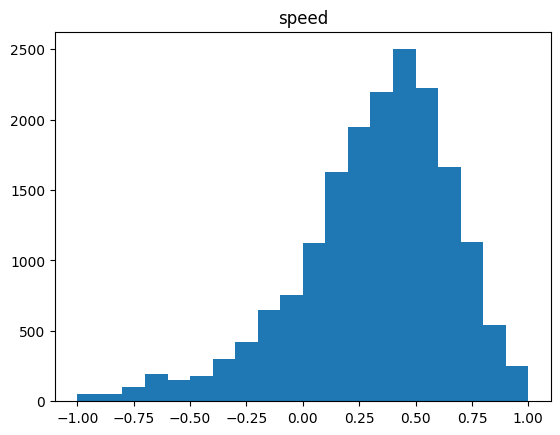

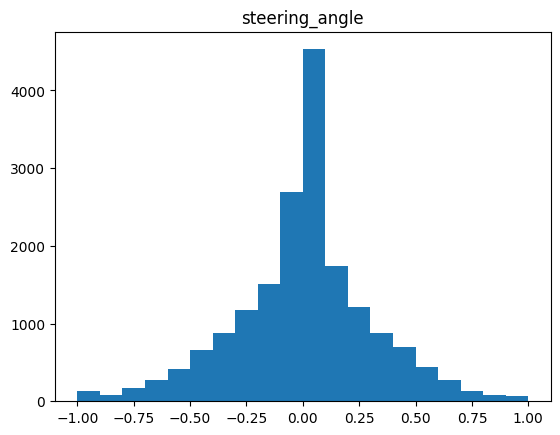

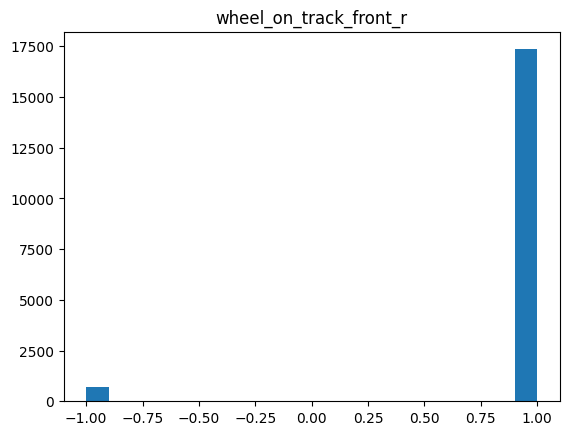

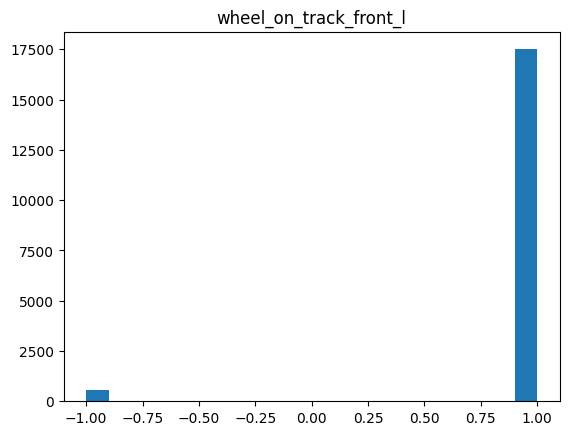

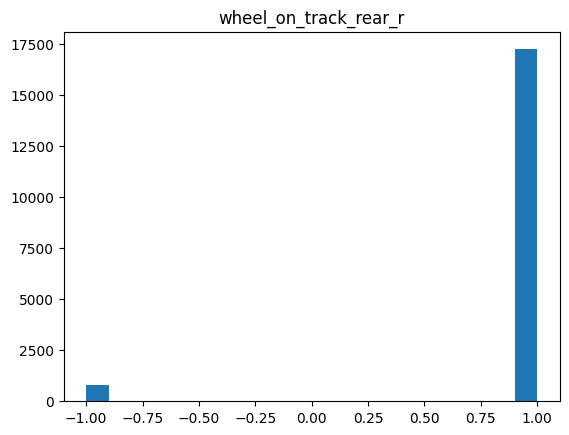

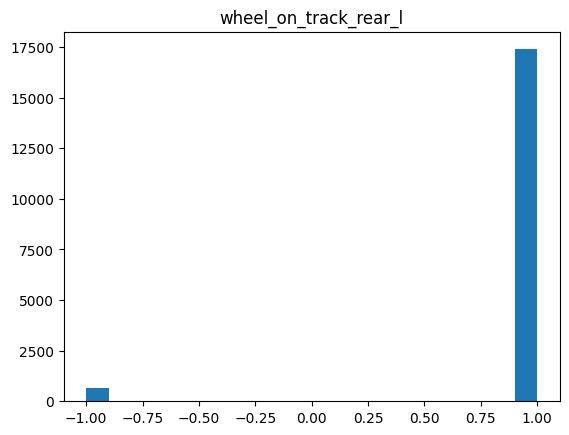

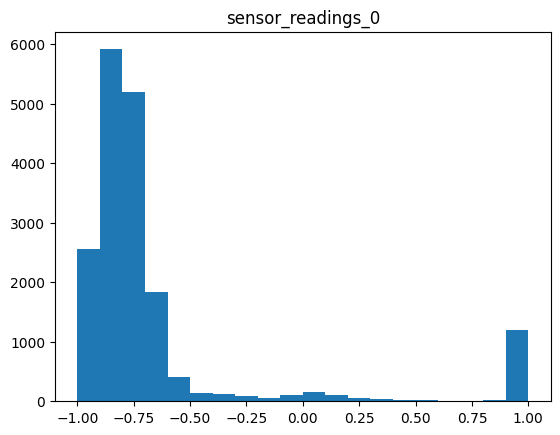

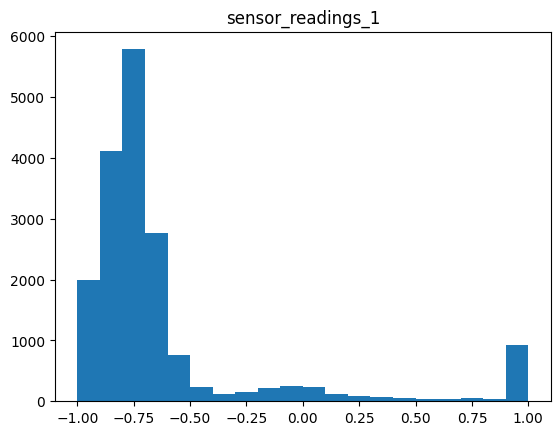

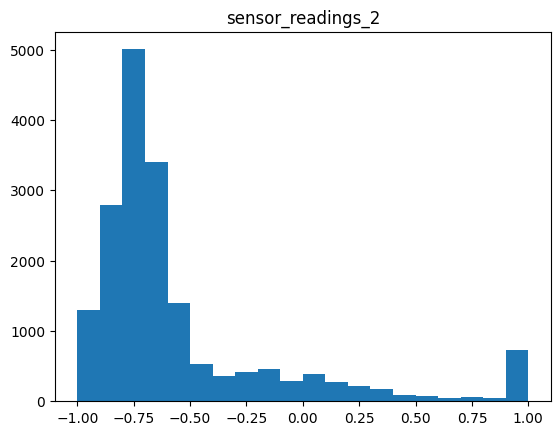

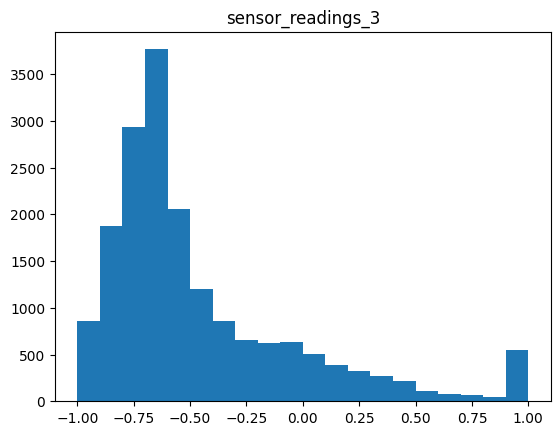

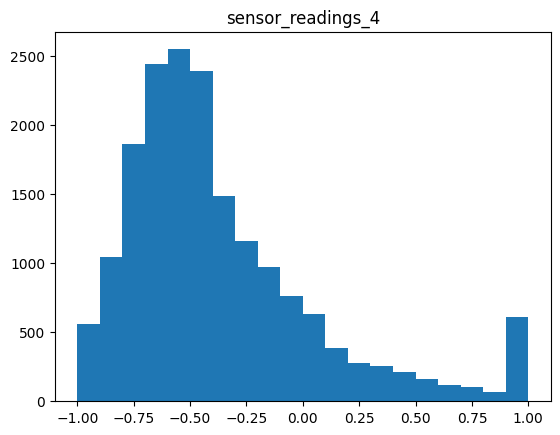

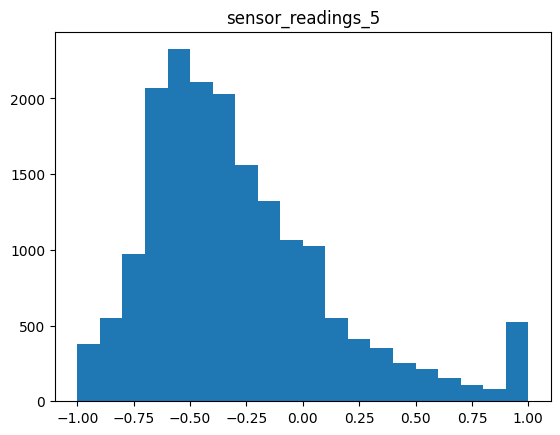

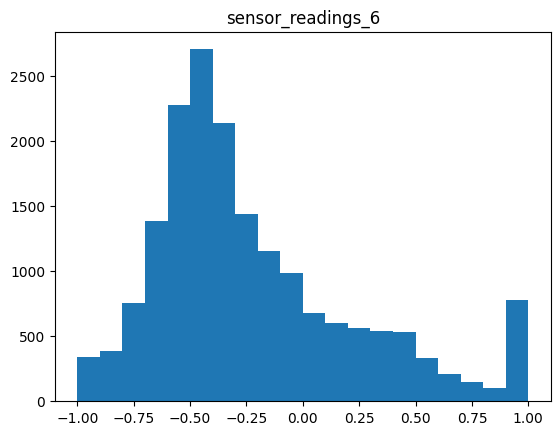

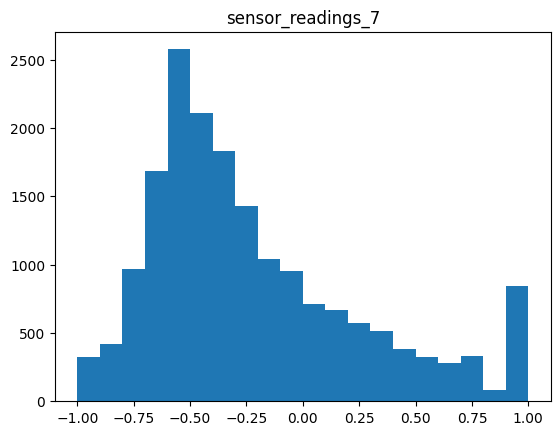

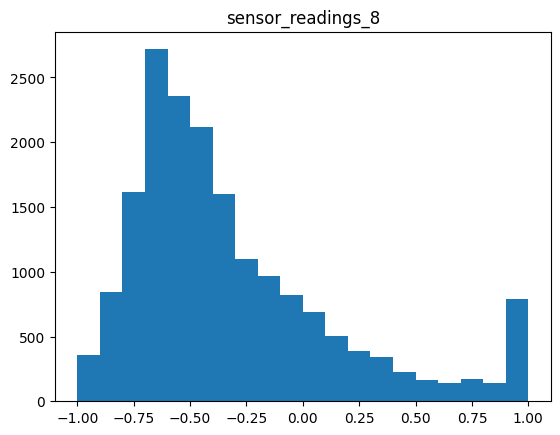

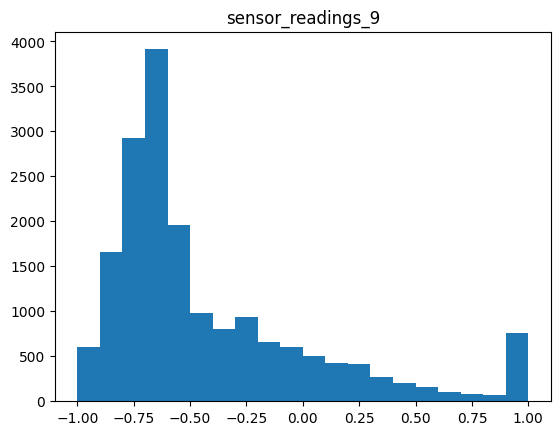

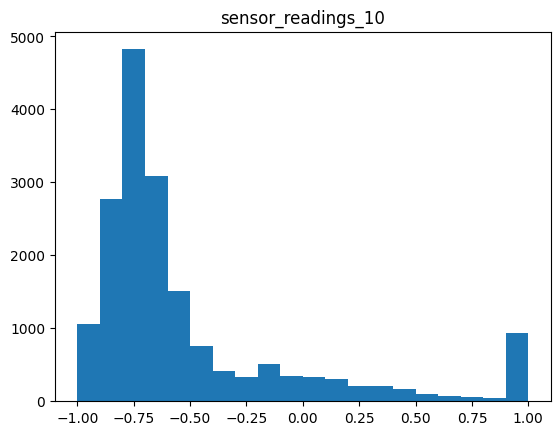

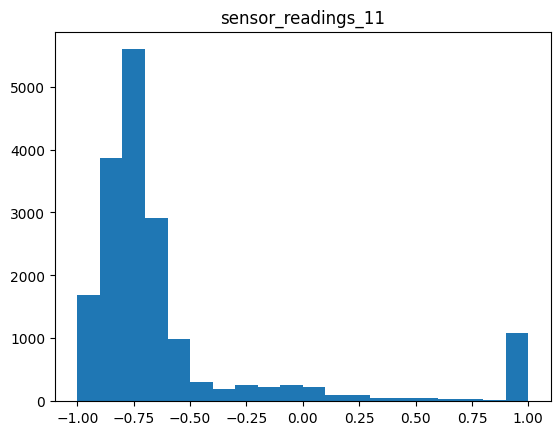

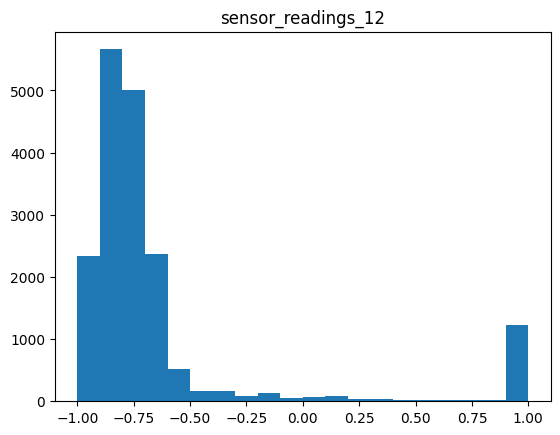

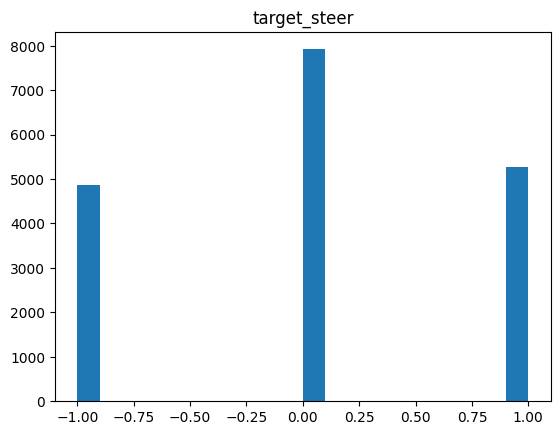

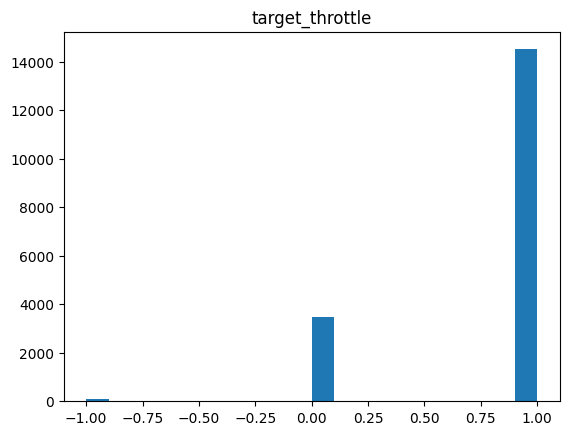

In [6]:
for column in data.columns:
    plt.figure()
    plt.title(column)
    plt.hist(data[column], bins=20)
    plt.show()

In [7]:
x = data[data.columns[:-2]].to_numpy()
x.shape

(18049, 19)

In [8]:
y = data[data.columns[-2:]].to_numpy()
y.shape

(18049, 2)

In [9]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.1, random_state=0)

In [10]:
class RacerDataset(Dataset):
    def __init__(self, x, y):
        self.x = t.tensor(x, dtype=t.float32)
        self.y = t.tensor(y, dtype=t.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = RacerDataset(x_train, y_train)
validation_dataset = RacerDataset(x_validation, y_validation)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [15]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 2),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.layers(x)

model = Model(x_train.shape[1])

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
epochs = 300
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        #print(f"{loss.item():.4f} ", end="", flush=True)
        loss.backward()
        optimizer.step()

    model.eval()
    with t.no_grad():
        validation_outputs = model(validation_dataset.x)
        validation_loss = criterion(validation_outputs, validation_dataset.y)

    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {loss.item():.4f}, "
        f"Validation Loss: {validation_loss.item():.4f}"
    )

Epoch 1/300, Train Loss: 0.4987, Validation Loss: 0.4910
Epoch 2/300, Train Loss: 0.4406, Validation Loss: 0.4229
Epoch 3/300, Train Loss: 0.3688, Validation Loss: 0.3544
Epoch 4/300, Train Loss: 0.3026, Validation Loss: 0.2966
Epoch 5/300, Train Loss: 0.2412, Validation Loss: 0.2485
Epoch 6/300, Train Loss: 0.2180, Validation Loss: 0.2204
Epoch 7/300, Train Loss: 0.2139, Validation Loss: 0.2092
Epoch 8/300, Train Loss: 0.2074, Validation Loss: 0.2029
Epoch 9/300, Train Loss: 0.1904, Validation Loss: 0.1976
Epoch 10/300, Train Loss: 0.1956, Validation Loss: 0.1928
Epoch 11/300, Train Loss: 0.1840, Validation Loss: 0.1887
Epoch 12/300, Train Loss: 0.1819, Validation Loss: 0.1849
Epoch 13/300, Train Loss: 0.1848, Validation Loss: 0.1816
Epoch 14/300, Train Loss: 0.1811, Validation Loss: 0.1786
Epoch 15/300, Train Loss: 0.1745, Validation Loss: 0.1757
Epoch 16/300, Train Loss: 0.1744, Validation Loss: 0.1731
Epoch 17/300, Train Loss: 0.1745, Validation Loss: 0.1707
Epoch 18/300, Train Los

In [28]:
dummy_input = t.randn(1, x_train.shape[1], dtype=torch.float32)
torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    #opset_version=11,               # ONNX version (11 is widely supported)
    #dynamo=True,
    input_names=["input"],          # names for inputs
    output_names=["output"],        # names for outputs
    dynamic_axes={                  # allow variable batch size
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    },
)

/tmp/ipykernel_90378/3138701648.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
